# 1 

A partir del fichero "US_Crime_Rates_1960_2014", se pide:

1. Tratar el dataset como una serie temporal a partir de la columna Year. Siempre el eje X será el nuevo índice Year.
2. Dibujar todas las columnas numéricas.
3. Como se puede ver en el punto 2, la columna "Population" tiene una magnitud diferente a la de las demás columnas: Dibuja la misma gráfica que antes pero con dos resoluciones diferentes para que se puedan observar con mejor detalle todas las columnas. 
4. A partir de ahora y para el resto del ejercicio, borra las columnas "Population" y "Total" ¿Qué columnas tienen mejor correlación? 
5. A partir de las cinco columnas que tengan mejor correlación con la columna "Murder", entrena un modelo de regresión no lineal a partir de polinomio de grado 6. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento.
6. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones=23 y n_repeats=7.

<AxesSubplot:xlabel='Year'>

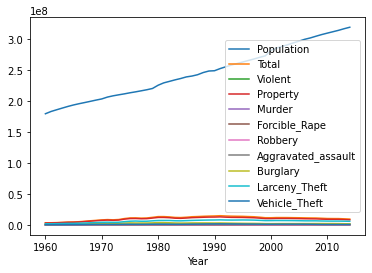

In [1]:
import pandas as pd
df = pd.read_csv("US_Crime_Rates_1960_2014.csv")

df.set_index("Year", inplace=True)
df.plot()

<AxesSubplot:xlabel='Year'>

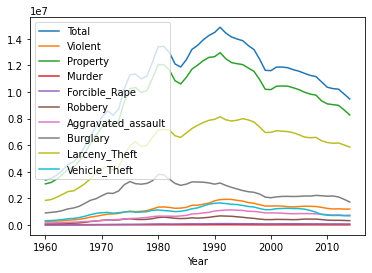

In [2]:
df.loc[:, 'Total':].plot()

In [3]:
df2 = df.loc[:, 'Violent':]
df2.head()

,Violent,Property,Murder,Forcible_Rape,Robbery,Aggravated_assault,Burglary,Larceny_Theft,Vehicle_Theft
Year,,,,,,,,,
1960,288460,3095700,9110,17190,107840,154320,912100,1855400,328200
1961,289390,3198600,8740,17220,106670,156760,949600,1913000,336000
1962,301510,3450700,8530,17550,110860,164570,994300,2089600,366800
1963,316970,3792500,8640,17650,116470,174210,1086400,2297800,408300
1964,364220,4200400,9360,21420,130390,203050,1213200,2514400,472800


<AxesSubplot:>

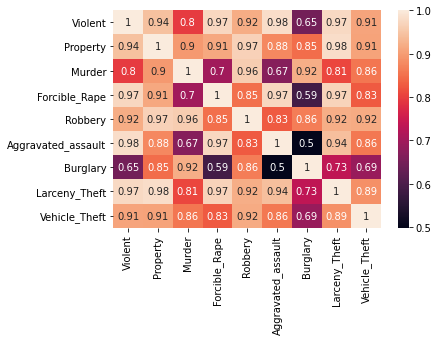

In [4]:
import seaborn as sns

sns.heatmap(df2.corr(), annot=True)

In [5]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs = {'Column_A':[], 'Column_B':[]}
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs['Column_A'].append(cols[i])
            pairs['Column_B'].append(cols[j])
    return pairs

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    pairs = get_redundant_pairs(df)
    tuple_pairs = list(zip(pairs['Column_A'], pairs['Column_B']))

    au_corr = au_corr.drop(labels=tuple_pairs).sort_values(ascending=False)
    df = pd.DataFrame(au_corr[0:n], columns=['Correlation'])
    df.reset_index(inplace=True)
    return df



In [6]:
cors = get_top_abs_correlations(df2, n=40)

In [7]:
cors.head()

,level_0,level_1,Correlation
0,Violent,Aggravated_assault,0.981071
1,Property,Larceny_Theft,0.980528
2,Violent,Larceny_Theft,0.974791
3,Forcible_Rape,Aggravated_assault,0.974379
4,Violent,Forcible_Rape,0.973914


In [8]:
cors[(cors.level_0 == 'Murder') | (cors.level_1 == 'Murder')].head(5)

,level_0,level_1,Correlation
7,Murder,Robbery,0.960156
11,Murder,Burglary,0.920207
17,Property,Murder,0.895641
22,Murder,Vehicle_Theft,0.856600
27,Murder,Larceny_Theft,0.806279


In [9]:
import numpy as np

X = np.array(df2.loc[:, ['Robbery', 'Burglary', 'Property', 'Vehicle_Theft', 'Larceny_Theft']])
y = np.array(df2['Murder'])

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [59]:
import warnings

def plot_crossval_scores(X, y, degree=6, splits=23, epochs=7, random_state=42, show_warnings=False):

    if show_warnings == False:
        warnings.filterwarnings('ignore')

    scores = {'Epoch':[],'Iteration':[],'Train_Score':[], 'Val_Score':[],'Train_MAE':[], 'Train_RMSE':[], 'Val_MAE':[], 'Val_RMSE':[]}
    epoch = 1
    iteration = 1

    # Cross Validation Data Collection
    polinominal_model = PolynomialFeatures(degree) 
    X_poly = polinominal_model.fit_transform(X, y)
    rkf = RepeatedKFold(n_splits=splits, n_repeats=epochs, random_state=random_state)
    lin_reg_model = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=random_state)

    for train_index, val_index in rkf.split(X_train):

        lin_reg_model.fit(X_train[train_index], y_train[train_index])
        train_score = lin_reg_model.score(X_train[train_index], y_train[train_index])
        val_score = lin_reg_model.score(X_train[val_index], y_train[val_index])

        scores['Train_Score'].append(train_score)
        scores['Val_Score'].append(val_score)
        scores['Iteration'].append(iteration)
        scores['Epoch'].append(epoch)

        y_pred = lin_reg_model.predict(X_train[train_index])
        y_pred_val = lin_reg_model.predict(X_train[val_index])

        scores['Train_MAE'].append(mean_absolute_error(y_train[train_index], y_pred))
        scores['Train_RMSE'].append(np.sqrt(mean_squared_error(y_train[train_index], y_pred)))
        scores['Val_MAE'].append(mean_absolute_error(y_train[val_index], y_pred_val))
        scores['Val_RMSE'].append(np.sqrt(mean_squared_error(y_train[val_index], y_pred_val)))
        
        iteration += 1
        if iteration > splits:
            iteration = 1
            epoch += 1

    # Epoch Plots
    df = pd.DataFrame(scores, index=range(len(scores['Val_Score'])))

    for e in range(1, epochs+1):
        x_plot = df[df.Epoch == e]['Iteration']
        y_plot_train = df[df.Epoch == e]['Train_Score']
        y_plot_val = df[df.Epoch == e]['Val_Score']
        fig, ax = plt.subplots()
        ax.plot(x_plot, y_plot_train, color='green', label='Train Score')
        ax.plot(x_plot, y_plot_val, color='red', label='Val Score')
        plt.title(f'Train/Val Score | Epoch: {e}')
        ax.legend(loc='best')
        plt.show()

    return df

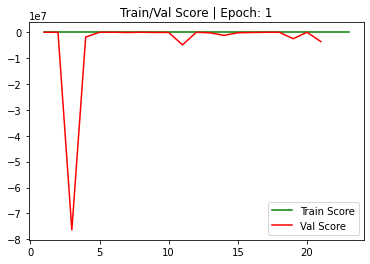

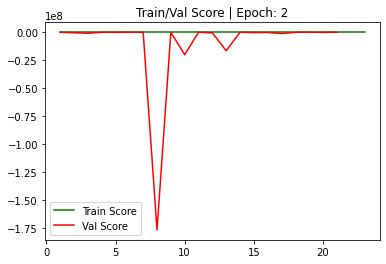

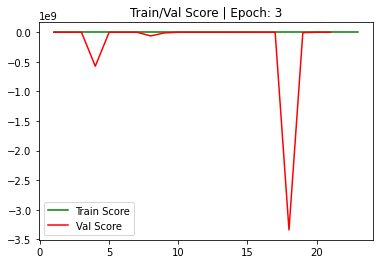

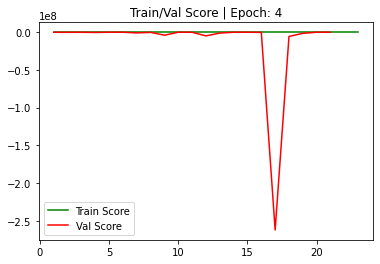

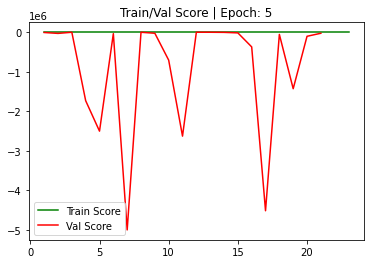

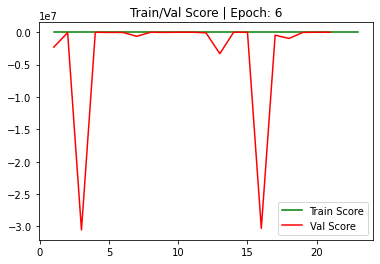

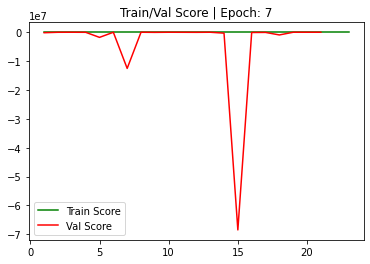

In [60]:
scores = plot_crossval_scores(X, y)

In [13]:
scores

,Epoch,Iteration,Train_Score,Val_Score,Train_MAE,Train_RMSE,Val_MAE,Val_RMSE
0,1,1,1.0,-5.766214e+03,0.000391,0.000449,2.672529e+05,2.830365e+05
1,1,2,1.0,-1.979153e+03,0.000289,0.000408,8.716067e+04,1.225723e+05
2,1,3,1.0,-7.638524e+07,0.000307,0.000392,1.028037e+06,1.310980e+06
3,1,4,1.0,-1.868403e+06,0.000404,0.000440,7.988541e+05,9.499925e+05
4,1,5,1.0,-6.592610e+00,0.000338,0.000422,8.518778e+03,8.674217e+03
...,...,...,...,...,...,...,...,...
156,7,19,1.0,-5.270997e+03,0.000928,0.001003,1.632366e+05,1.837359e+05
157,7,20,1.0,-3.115891e+03,0.000503,0.000591,1.209413e+05,1.340178e+05
158,7,21,1.0,-3.539830e+03,0.050365,0.064302,3.345889e+05,4.727662e+05
159,7,22,1.0,NaN,0.000481,0.000599,1.038949e+03,1.038949e+03
